# A Pseudoproxy Experiment with GraphEM and pseudoPAGES2k

**Expected time to run through: TBD mins**

This tutorial demonstrates how to get a reconstruction using GraphEM, leveraging a simple pseudoproxy dataset generated from iCESM gridded, with the realistic spatial availability but full temporal availablity of the PAGES 2k version 2 dataset.
The pseudoproxies are generated based on the original iCESM simulated surface temperature (`tas`) plus white noise with `SNR=10`. While with LMR it is advantageous to have many redundant proxies (as long as they are unbiased, which is the case here), with GraphEM this can lead to some counter-intuitive difficulties, which we explain below.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt

## Data Preparation

(<Figure size 720x720 with 1 Axes>, {'map': <GeoAxesSubplot:>})

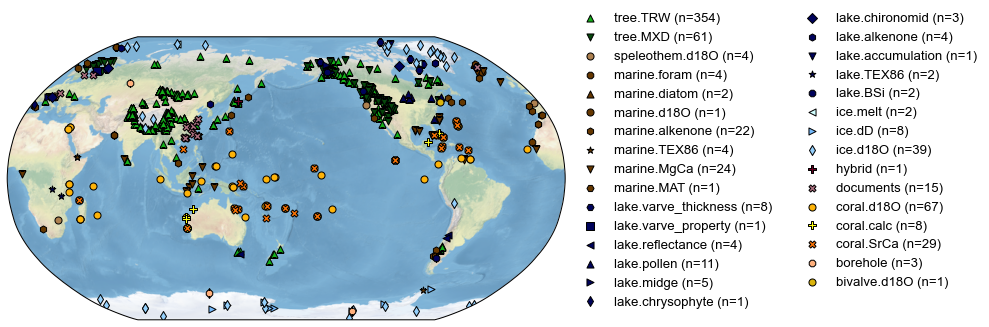

In [2]:
# load a proxy database
job = cfr.ReconJob()
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10.pkl')
job.proxydb.plot()

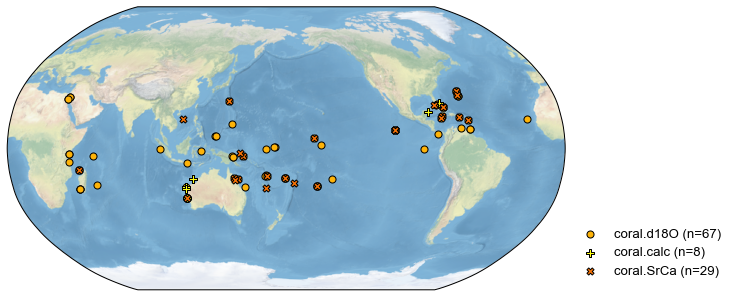

In [3]:
# filter the database
job.proxydb = job.proxydb.filter(by='ptype', keys='coral')
fig, ax = job.proxydb.plot()

In [4]:
job.proxydb = job.proxydb.center([1951, 1980])

Centering each of the ProxyRecord: 100%|██████████| 104/104 [00:00<00:00, 8366.24it/s]


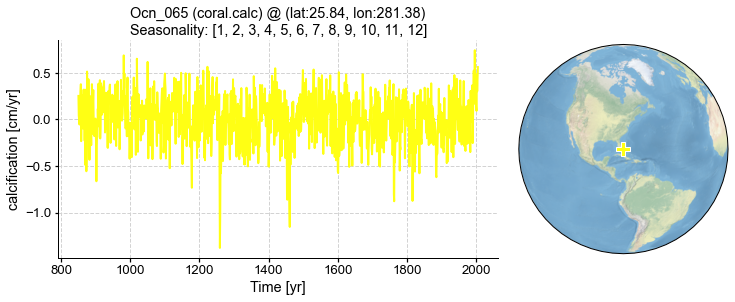

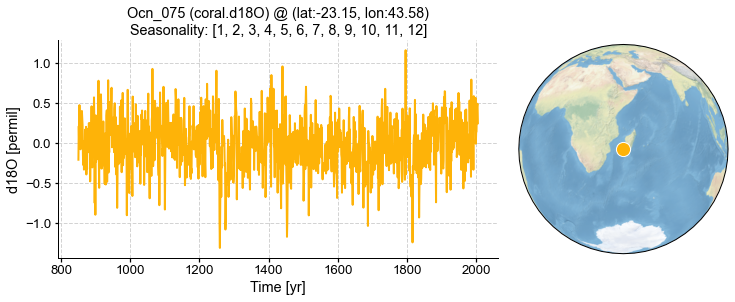

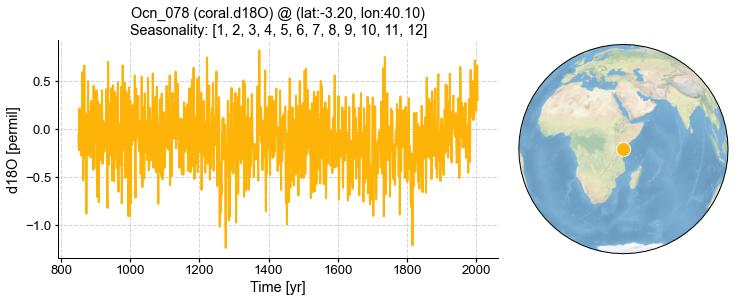

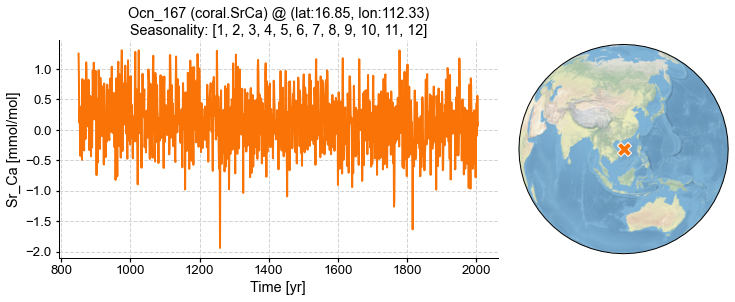

In [7]:
# loop over the proxy database
for i, pobj in enumerate(job.proxydb):
    fig, ax = pobj.plot()
    if i == 3: break

In [8]:
# load observations
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


In [9]:
# regrid and crop obs to make the problem size smaller
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
#job.regrid_clim(tag='obs', nlat=32, nlon=50, verbose=True)
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


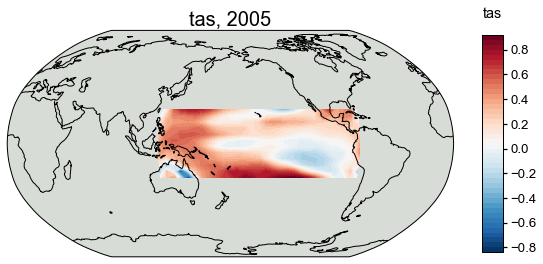

In [10]:
# annualize the observations
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))
fig, ax = job.obs['tas'].plot(it=-1)

In [11]:
job.obs['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 12, lon: 28)>
array([[[-1.43779302, -1.16293697, -1.01732908, ...,  0.39457998,
          0.52082612,  0.59373487],
        [-0.44181921, -0.51548275,  0.244261  , ...,  0.74474864,
          0.77145844,  0.68355714],
        [ 0.35079578,  0.32100882,  0.55368277, ...,  0.88217642,
          0.68757142,  0.31475473],
        ...,
        [ 0.72816369,  0.71887253,  0.54529944, ...,  0.20676015,
          0.30845679,  0.2907033 ],
        [ 1.10758701,  0.98782858,  1.00810014, ...,  0.09055938,
          0.18384386,  0.24694595],
        [ 1.31631178,  1.20505177,  1.04198581, ...,  0.14300547,
          0.29674634,  0.27620213]],

       [[-0.70474708, -0.01598469,  0.13178037, ..., -0.16622394,
         -0.03184134, -0.0226782 ],
        [-0.47576783, -0.55773132, -0.46185074, ..., -0.03219556,
          0.01012642,  0.01045555],
        [ 0.10615215, -0.04668079, -0.21236786, ...,  0.06428793,
         -0.00198371, -0.03837104],
...
        [ 0.25181528,  0.44903654,  0.61978375, ...,  0.31308888,
          0.36723991,  0.52567691],
        [ 0.04978446,  0.04787485,  0.22568625, ...,  0.45198041,
          0.4664865 ,  0.49749394],
        [ 0.10458478, -0.10605026, -0.21279729, ...,  0.54345012,
          0.54446683,  0.52080011]],

       [[ 0.0498074 ,  0.27873075,  0.39957376, ..., -0.03960866,
         -0.05272122,  0.16753688],
        [-0.37810031,  0.30122609, -0.0628949 , ..., -0.11026585,
          0.06519481,  0.26313251],
        [ 0.08783609, -0.448483  , -0.12010821, ..., -0.0352111 ,
          0.10163381,  0.12676614],
        ...,
        [ 0.09630422,  0.35422082,  0.39387372, ...,  0.24968949,
          0.3645677 ,  0.26936438],
        [-0.06625534,  0.26004941,  0.47504105, ...,  0.32676493,
          0.46907017,  0.4533393 ],
        [-0.19586628,  0.12946299,  0.54914526, ...,  0.38060853,
          0.41296104,  0.51346773]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 121.9 127.7 133.5 139.4 ... 261.3 267.1 272.9 278.7
  * lat      (lat) float64 -24.15 -19.76 -15.37 -10.98 ... 15.37 19.76 24.15

The method `prep_graphem()` helps weave everything into an object that the code can work with:

In [12]:
job.prep_graphem(
    recon_period=(1001, 2000),
    calib_period=(1850, 2000),
    verbose=True)

>>> job.configs["recon_period"] = (1001, 2000)
>>> job.configs["recon_timescale"] = 1
>>> job.configs["calib_period"] = (1850, 2000)
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


In [13]:
job.obs.keys()

dict_keys(['tas'])

In [14]:
job.graphem_params['field']

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.70970161, 0.73450522, 0.30319882, ..., 0.34267614, 0.25509715,
        0.39273508],
       [0.57543254, 0.4847614 , 0.17716476, ..., 0.26505406, 0.25998264,
        0.37178005],
       [0.66133266, 0.97367383, 1.02246066, ..., 0.0466115 , 0.12031657,
        0.13679344]])

In [15]:
job.graphem_params['df_proxy']

,Ocn_065,Ocn_075,Ocn_078,Ocn_167,Ocn_091,Ocn_093,Ocn_096,Ocn_086,Ocn_101,Ocn_070,...,Ocn_090,Ocn_119,Ocn_109,Ocn_097,Ocn_159,Ocn_087,Ocn_153,Ocn_169,Ocn_071,Ocn_072
1001,-0.140959,-0.189079,-0.644011,0.880971,-0.353627,-0.385136,0.391605,0.085740,-0.142097,-0.340745,...,-0.256542,-0.681228,-0.107835,-0.306781,-0.702228,-0.623715,-0.340019,-0.299727,-0.381977,-0.434130
1002,-0.328157,-0.321275,-0.768532,-0.134462,-0.466426,-0.464541,-0.360408,-0.322270,-0.726876,-0.370234,...,-0.878023,-0.154431,-0.441021,-0.814996,-0.137507,0.659337,-0.292360,-0.240576,-0.315910,-0.321662
1003,-0.034775,0.215581,0.127060,0.418030,0.032097,0.019269,-0.293432,-0.197375,-0.151304,-0.168714,...,-0.139732,-0.122919,-0.001701,-0.075053,-0.066685,0.045808,0.486391,0.233443,0.199105,0.287433
1004,-0.404619,-0.004652,-0.033988,0.331707,0.005884,0.124065,0.264037,0.170465,0.425361,-0.348162,...,0.086318,-0.432750,0.353831,0.132764,-0.420036,-0.277734,-0.059898,-0.119616,-0.127324,-0.156512
1005,0.240355,-0.155001,-0.165279,0.239481,0.126819,0.135213,-0.112592,-0.097805,-0.178961,0.101278,...,-0.051588,-0.426429,0.021374,-0.106965,-0.393301,-0.607173,0.041356,-0.303574,-0.406007,-0.310617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.743697,0.338284,0.715508,0.162016,-0.026747,-0.007325,-0.575463,0.000148,0.369746,0.788341,...,0.295276,0.612787,-0.353173,0.334679,0.585727,0.333138,0.916858,0.460754,0.352439,0.394136
1997,0.252507,0.288798,0.491229,0.036127,0.515565,0.451677,0.562752,0.387139,0.391077,0.231005,...,0.517200,0.029481,0.553338,0.508313,0.009796,-0.565929,0.184676,0.046032,-0.189919,-0.189621
1998,0.451207,0.568643,0.317675,-0.777927,0.707404,0.634549,0.378939,0.199019,0.325382,0.370420,...,0.346750,0.640202,0.750806,0.354143,0.594861,1.149865,0.487082,0.071782,-0.010558,-0.003490
1999,0.475024,-0.006458,0.581197,0.100207,0.321173,0.413073,-0.033693,0.329739,0.882220,0.333502,...,0.354694,0.381620,0.170468,0.392791,0.354186,0.101773,0.506631,0.470518,0.506725,0.399847


In [16]:
print(np.shape(job.graphem_params['field']))
print(np.shape(job.graphem_params['proxy']))
print(np.shape(job.graphem_params['lonlat']))

(1000, 336)
(1000, 104)
(440, 2)


## Graph estimation

In GraphEM, the selection of the covariance model used for inferring missing values is based on a [graph](http://ir.hit.edu.cn/~jguo/docs/notes/report-in-princeton-research.pdf). 
Two types of graphs are supported:
1. Neighborhood graphs
2. Empirical graphs (graphical lasso)


## 1. Neighborhood graph as initial guess

In [17]:
g0 = cfr.graphem.Graph(
    job.graphem_params['lonlat'],
    job.graphem_params['field'],
    job.graphem_params['proxy'])

Let us define a neighborhood graph by including only points within a cutoff_radius $R$ of each grid point or proxy locale. The location takes a bit of time the first time around as the matrix of mutual great- circle distances needs to be computed: 

In [18]:
g0.neigh_adj(cutoff_radius=1500)

Next we plot the temperature neighbors of a particular proxy to show what happened:

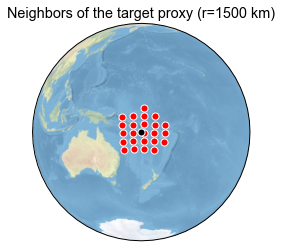

In [19]:
i = 20  # index of proxy
fig, ax = g0.plot_neighbors(i)

This, however, does not tell us the degree to which this proxy correlates to temperature at nerby grid points over the instrumental era. To do that, we use:

(<Figure size 360x360 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors of the target proxy (r=1500 km)'}>)

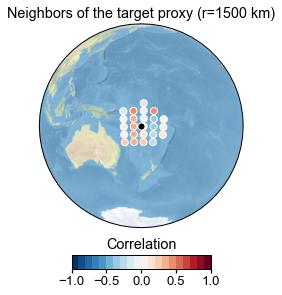

In [20]:
g0.plot_neighbors_corr(i)

This can be instructive for small proxy networks, or for debugging purposes. For a bird's eye view of the graph, we instead plot the adjacency matrix itself (dots indicate neighbors):

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:xlabel='Index'>)

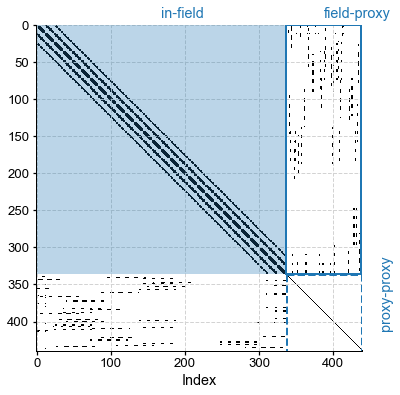

In [21]:
g0.plot_adj()

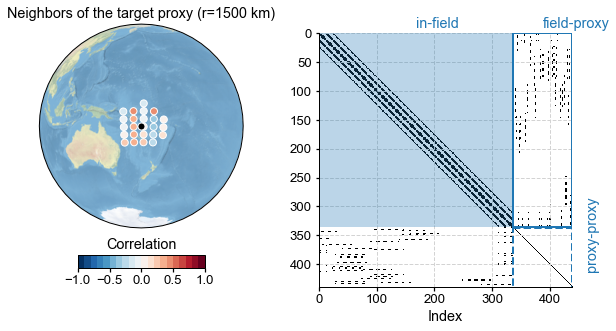

In [22]:
# an example of passing axes with map projections
import cartopy.crs as ccrs
from matplotlib import gridspec

# we need to first make a plot with map projections to get the specific projection,
# otherwise we have ot set it manually later
i = 20 # proxy index
fig_map, ax_map = g0.plot_neighbors(i)
cfr.closefig(fig_map)  # mute the figure

# now we make a new figure to include subplots generated by
# `plot_neighbors()` or `plot_neighbors_corr()` and `plot_adj()`
fig = plt.figure(figsize=[10, 5])
ax = {}
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.2)
# the 1st subplot will use the exact projection we had earlier
ax['map'] = fig.add_subplot(gs[0], projection=ax_map.projection)
ax['adj'] = fig.add_subplot(gs[1])
# we may call `plot_neighbors_corr()` since it has the same projection
ax['map'] = g0.plot_neighbors_corr(i, ax=ax['map'])
ax['adj'] = g0.plot_adj(ax=ax['adj'])

By construction, proxies are assumed conditionally independent of each other, so the proxy-proxy part of the adjacency matrix is diagonal. The climate-climate is block-diagonal, reflecting the fact that nearby indices tend to reflect nearby gridpoints, and nearby gridpoints generally have similar climates*.  There are discontinuities that happen when cycling through longitudes (0 --> 360 back to 0), which show up as abrupt breaks in the graph. The climate-proxy part is less regular, reflecting the fact that proxy locations are not uniformly spaced (unlike the grid points of the climate field). Notice how the overall matrix is very __sparse__: only a handful of of entries are non-zero (white is the main color on this plot). To be more precise, the `sparsity` property quantifies the fraction of non-zero entries:

In [23]:
g0.sparsity

[0.05653873489694385, 0.03345352564102564, 0.0]

We see that only a few % of the graph of the climate field and of the climate-proxy graph, have non-zero entries (the diagonal is excluded from this calculation, because a random variable is always conditionally dependent on itself; therefore, the proxy-proxy part of the graph has a sparsity of 0). This graph has achieved what we want: reducing the number of parameters to be estimated while computing the covariance matrix, which otherwise would be ill-conditioned. Will this suffice to yield a good estimate? Or have we thrown out the rubber duckies with the bath water and jettisoned too much information? The control knob here is the cutoff-radius. If it is too generous, the model is under-regularized; if it is too small, it could be over-regularized. What then is the optimal choice? Unfortunately, there is no theoretical criterion on how to choose an appropriate one. At a minimum, it should be larger than the largest spacing between nearby grid points (which tends to be largest at the equator). At most, it should be the circumference of the planet. That leaves quite some room in between. We will first carry out a preliminary reconstruction, before refining the choice of cutoff-radius via a process called [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

## Preliminary reconstruction

In [24]:
job.run_graphem?

Signature:
job.run_graphem(
    save_dirpath,
    load_precalculated=True,
    verbose=False,
    compress_params=None,
    recon_timescale=None,
    **fit_kws,
)
Docstring:
Run the GraphEM solver, essentially the :py:meth: `GraphEM.solver.GraphEM.fit` method

Note that the arguments for :py:meth: `GraphEM.solver.GraphEM.fit` can be appended in the
argument list of this function directly. For instance, to pass a pre-calculated graph, use
`estimate_graph=False` and `graph=g.adj`, where `g` is the :py:`Graph` object.

Args:
    save_dirpath (str): the path to save the related results
    load_precalculated (bool, optional): load the precalculated `Graph` object. Defaults to False.
    verbose (bool, optional): print verbose information. Defaults to False.
    fit_kws (dict): the arguments for :py:meth: `GraphEM.solver.GraphEM.fit`

See also:
    cfr.graphem.solver.GraphEM.fit : fitting the GraphEM method
File:      ~/Github/cfr/cfr/reconjob.py
Type:      method


In [30]:
%%time
job.run_graphem(
    save_dirpath='./results/graphem-ppe-pages2k',
    load_precalculated=False,
    verbose=True,
    estimate_graph=False,
    graph=g0.adj,
)

>>> job.configs["save_dirpath"] = ./results/graphem-ppe-pages2k
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.0592     0.8600
002     0.2571     2.8020
003     0.0958     0.3083
004     0.0494     0.1295
005     0.0321     0.0781
006     0.0264     0.0616
007     0.0231     0.0521
008     0.0207     0.0457
009     0.0190     0.0412
010     0.0181     0.0386
011     0.0164     0.0343
012     0.0156     0.0323
013     0.0139     0.0284
014     0.0127     0.0257
015     0.0118     0.0236
016     0.0120     0.0238
017     0.0107     0.0211
018     0.0100     0.0196
019     0.0095     0.0184
020     0.0091     0.0175
021     0.0101     0.0194
022     0.0088     0.0169
023     0.0082     0.0156
024     0.0077     0.0146
025     0.0073     0.0138
026     0.0069     0.0130
027     0.0066     0.0123
028     0.0063     0.0117
029     0.0060     0.0111
030     0.0057     0.0105
031     0.0054     0.0100
032     0.0052     0.0095
033     0.0049     0.0091
034     0.0

## Validation

In [32]:
res = cfr.ReconRes('./results/graphem-ppe-pages2k', verbose=True)

>>> recon.paths:
['./results/graphem-ppe-pages2k/job_r01_recon.nc']


In [33]:
res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


In [34]:
mask = (job.obs['tas'].time >= 1001) & (job.obs['tas'].time <= 2000)
target = job.obs['tas'].da.values[mask]
print(np.shape(target))

(1000, 12, 28)


### Mean Statistics

In [37]:
nt = np.size(res.recons['tas'].time)
field_r = job.graphem_solver.field_r
V = cfr.graphem.solver.verif_stats(
    field_r, target.reshape((nt, -1)),
    job.graphem_params['calib_idx'])
print(V)

Mean MSE = 0.1044, Mean RE = 0.5215, Mean CE = 0.4589, Mean R2 = 0.6391


### Map of CE

In [39]:
ce = cfr.utils.coefficient_efficiency(target, res.recons['tas'].da.values)
print(np.shape(ce))

(12, 28)


/var/folders/4b/jg2fv7tn0g5gwzkq0s84c0ww0000gn/T/ipykernel_48160/2942537339.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(


Text(0.5, 1.0, 'CE')

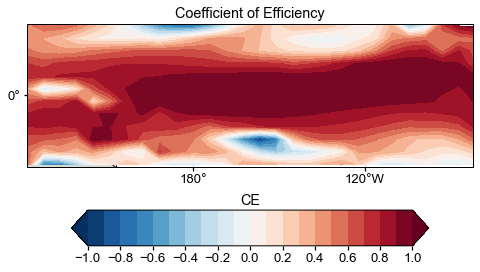

In [40]:
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Coefficient of Efficiency')
# latlon_range = [0, 360, -90, 90]
latlon_range = [122, 278, -25, 25]
transform=ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

lon_ticks=[60, 120, 180, 240, 300]
lat_ticks=[-90, -45, 0, 45, 90]
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
lon_min, lon_max, lat_min, lat_max = latlon_range
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks[mask_lat], crs=ccrs.PlateCarree())

levels = np.linspace(-1, 1, 21)
cbar_labels = np.linspace(-1, 1, 11)
cbar_title = 'CE'
extend = 'both'
cmap = 'RdBu_r'
cbar_pad=0.1
cbar_orientation='horizontal'
cbar_aspect=10
cbar_fraction=0.35
cbar_shrink=0.8
font_scale=1.5
land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['white']
        
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()
im = ax.contourf(job.obs['tas'].lon, job.obs['tas'].lat, ce, levels, transform=transform, cmap=cmap, extend=extend)
cbar = fig.colorbar(
    im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.set_ticks(cbar_labels)
cbar.ax.set_title(cbar_title)

### Timeseries comparison

In [44]:
job.obs['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 12, lon: 28)>
array([[[-1.43779302, -1.16293697, -1.01732908, ...,  0.39457998,
          0.52082612,  0.59373487],
        [-0.44181921, -0.51548275,  0.244261  , ...,  0.74474864,
          0.77145844,  0.68355714],
        [ 0.35079578,  0.32100882,  0.55368277, ...,  0.88217642,
          0.68757142,  0.31475473],
        ...,
        [ 0.72816369,  0.71887253,  0.54529944, ...,  0.20676015,
          0.30845679,  0.2907033 ],
        [ 1.10758701,  0.98782858,  1.00810014, ...,  0.09055938,
          0.18384386,  0.24694595],
        [ 1.31631178,  1.20505177,  1.04198581, ...,  0.14300547,
          0.29674634,  0.27620213]],

       [[-0.70474708, -0.01598469,  0.13178037, ..., -0.16622394,
         -0.03184134, -0.0226782 ],
        [-0.47576783, -0.55773132, -0.46185074, ..., -0.03219556,
          0.01012642,  0.01045555],
        [ 0.10615215, -0.04668079, -0.21236786, ...,  0.06428793,
         -0.00198371, -0.03837104],
...
        [ 0.25181528,  0.44903654,  0.61978375, ...,  0.31308888,
          0.36723991,  0.52567691],
        [ 0.04978446,  0.04787485,  0.22568625, ...,  0.45198041,
          0.4664865 ,  0.49749394],
        [ 0.10458478, -0.10605026, -0.21279729, ...,  0.54345012,
          0.54446683,  0.52080011]],

       [[ 0.0498074 ,  0.27873075,  0.39957376, ..., -0.03960866,
         -0.05272122,  0.16753688],
        [-0.37810031,  0.30122609, -0.0628949 , ..., -0.11026585,
          0.06519481,  0.26313251],
        [ 0.08783609, -0.448483  , -0.12010821, ..., -0.0352111 ,
          0.10163381,  0.12676614],
        ...,
        [ 0.09630422,  0.35422082,  0.39387372, ...,  0.24968949,
          0.3645677 ,  0.26936438],
        [-0.06625534,  0.26004941,  0.47504105, ...,  0.32676493,
          0.46907017,  0.4533393 ],
        [-0.19586628,  0.12946299,  0.54914526, ...,  0.38060853,
          0.41296104,  0.51346773]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 121.9 127.7 133.5 139.4 ... 261.3 267.1 272.9 278.7
  * lat      (lat) float64 -24.15 -19.76 -15.37 -10.98 ... 15.37 19.76 24.15

In [47]:
da = cfr.utils.geo_mean(job.obs['tas'].da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
da
ref_time = da.year.values
ref_value = da.values
ref_name = 'truth'

(1000.0, 2000.0)

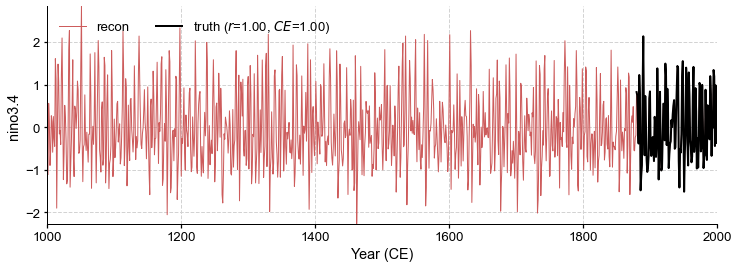

In [57]:
fig, ax = res.recons['nino3.4'].validate(ref_time, ref_value, ref_name).plot()
ax.set_xlim(1000, 2000)

In [63]:
lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pobj in job.proxydb:
    pid = pobj.pid
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 200

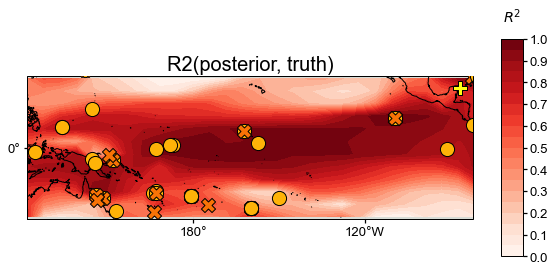

In [64]:
stat = 'R2'
valid_fd = res.recons['tas'].validate(
    job.obs['tas'], stat=stat,
    valid_period=(1750, 1850),
    interp_direction='from-ref',
)
fig, ax = valid_fd.plot(
    title=f'{stat}(posterior, truth)',
    projection='PlateCarree',
    latlon_range=(-25, 25, 122, 278),
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors,
    **valid_fd.plot_kwargs)

## Cross-validation